### 导包

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #默认为'last'
%matplotlib inline
import torch
import os
import re
import sys
import numpy as np
# from urllib import request
import urllib
import json
from matplotlib import pyplot as plt

In [2]:
from torch.nn import functional as F

## 激活函数

### mish

softplus函数  
$\zeta=log(1+exp(x))$

In [7]:
def zeta(x):
    return np.log(1+np.exp(x))
def mish(x):
    return x*np.tanh(zeta(x))

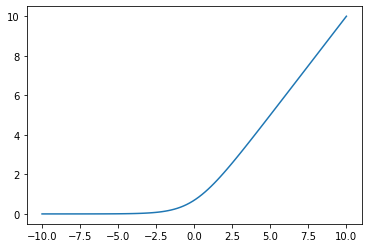

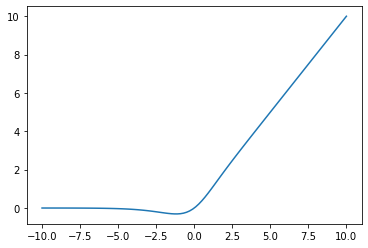

In [9]:
a = np.linspace(-10,10,100)
b = zeta(a)
c = mish(a)
plt.plot(a,b)
plt.show()
plt.plot(a,c)
plt.show()

In [ ]:
class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()
    def forward(self, x):
        y = x*torch.tanh(F.softplus(x))
        return y
        

### swish

# UNet

## 损失函数

### dice loss


(10, 25)

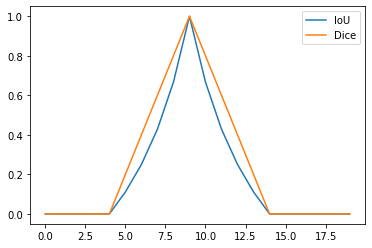

In [8]:
import numpy as np

a=np.ones((10,5))
b=np.zeros((10,5))

A = np.c_[a,b,b,b,b] #区域是10*5，两边补0
B = np.c_[b,b,a,b,b]
# A
A.shape
iou =[]
dice =[]

for i in range(20):
    A[:,[i,i+5]] = A[:,[i+5,i]] #A向右移动
#     A
    interArea =np.multiply(A,B)  #交集
    tem =A + B
    unionArea = tem - interArea    #并集
    inter=np.sum(interArea)
    union=np.sum(unionArea)
              
    dice_tem = inter * 2 / (5 * 10 * 2)
    iou_tem = inter / union
    iou.append(iou_tem)
    dice.append(dice_tem)
    
from matplotlib import pyplot
import matplotlib.pyplot as plt

x=range(len(dice))
plt.plot(x, iou, mec='r', mfc='w',label='IoU')
plt.plot(x, dice, mec='b', mfc='w',label='Dice')
plt.legend()


In [6]:
a = np.arange(10)
i = 2
a[[i,i+5]] = a[[i+5, i]]
a

array([0, 1, 7, 3, 4, 5, 6, 2, 8, 9])

### focal loss

In [32]:
# 针对多分类任务的 CELoss 和　Focal Loss
import torch
import torch.nn as nn
import torch.nn.functional as F

class CELoss(nn.Module):
    def __init__(self, class_num, alpha=None, use_alpha=False, size_average=True):
        super(CELoss, self).__init__()
        self.class_num = class_num
        self.alpha = alpha
        if use_alpha:
            self.alpha = torch.tensor(alpha).cuda()

        self.softmax = nn.Softmax(dim=1)
        self.use_alpha = use_alpha
        self.size_average = size_average

    def forward(self, pred, target):
        prob = self.softmax(pred.view(-1,self.class_num))
        prob = prob.clamp(min=0.0001,max=1.0)
        
        target_ = torch.zeros(target.size(0),self.class_num).cuda()
        target_.scatter_(1, target.view(-1, 1).long(), 1.)
        
        if self.use_alpha:
            batch_loss = - self.alpha.double() * prob.log().double() * target_.double()
        else:
            batch_loss = - prob.log().double() * target_.double()
        
        batch_loss = batch_loss.sum(dim=1)

        # print(prob[0],target[0],target_[0],batch_loss[0])
        # print('--')

        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()

        return loss

class FocalLoss(nn.Module):
    def __init__(self, class_num, alpha=None, gamma=2, use_alpha=False, size_average=True,device=torch.device("cpu")):
        super(FocalLoss, self).__init__()
        self.class_num = class_num
        self.alpha = alpha
        self.gamma = gamma
        if use_alpha:
            self.alpha = torch.tensor(alpha)

        self.softmax = nn.Softmax(dim=1)
        self.use_alpha = use_alpha
        self.size_average = size_average
        self.device = device

    def forward(self, pred, target):
        prob = self.softmax(pred.view(-1,self.class_num))
        prob = prob.clamp(min=0.0001,max=1.0)
        
        target_ = torch.zeros(target.size(0),self.class_num).to(self.device)
        target_.scatter_(1, target.view(-1, 1).long(), 1.)

        if self.use_alpha:
            batch_loss = - self.alpha * torch.pow(1-prob,self.gamma) * prob.log() * target_
        else:
            batch_loss = - torch.pow(1-prob,self.gamma) * prob.log() * target_

        batch_loss = batch_loss.sum(dim=1)

        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()

        return loss

In [15]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))

In [35]:
focalloss = FocalLoss(2, device=torch.device("cpu"))
x = sigmoid(torch.randn(10,2))
y = torch.randint(0,2,size=(10,))
# x = x.cuda()
# y = y.cuda()
y
loss = focalloss(x, y)
loss

tensor([1, 0, 0, 1, 1, 1, 0, 1, 1, 0])

tensor(0.2004)